In [7]:
import cv2
import os
from pathlib import Path
from matplotlib import pyplot as plt
import math
import numpy as np
from tqdm import tqdm

In [8]:
path = Path("Dataset_TP3")
videos_paths = [p for p in path.iterdir() if p.is_file()]

videos: dict[Path, cv2.VideoCapture] = {}
for file in videos_paths:
    vid = cv2.VideoCapture(file)
    if not vid.isOpened():
        print("Error: Could not open video.")
        continue
    videos[file] = vid
    break

In [ ]:
interactive = False
r = 50  # number of radial bins
edge_threshold = 30  # threshold for binary edge detection

edges = {}

print(f"Processing {len(videos)} videos")
for video_path, video in videos.items():
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))

    edge_maps = np.zeros((frame_count, h, w), dtype=np.uint8)
    histograms = np.zeros((frame_count, r), dtype=np.float32)

    center_y, center_x = h // 2, w // 2
    y, x = np.ogrid[:h, :w]
    distances = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    bin_size = np.max(distances) / r

    bin_indices = np.clip((distances / bin_size).astype(np.int32), 0, r - 1)

    for frame_idx in tqdm(range(frame_count)):
        ret, frame = video.read()
        if not ret:
            print(f"Error: Could not read frame {frame_idx}.")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        sobel_x = cv2.Sobel(
            gray, cv2.CV_32F, 1, 0, ksize=3
        )  # Use float32 instead of float64
        sobel_y = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)

        magnitude = cv2.magnitude(sobel_x, sobel_y)  # Faster than np.sqrt
        edge_maps[frame_idx] = (magnitude > edge_threshold).astype(np.uint8)

        for i in range(r):
            mask = bin_indices == i
            if np.any(mask):
                histograms[frame_idx, i] = np.mean(magnitude[mask])

        if interactive:
            display = cv2.convertScaleAbs(magnitude)
            cv2.imshow("Edges", display)
            if cv2.waitKey(int(1000 / fps)) & 0xFF == ord("q"):
                break

    edges[video_path] = {"edge_maps": edge_maps, "histograms": histograms}
    video.set(cv2.CAP_PROP_POS_FRAMES, 0)

Processing 1 videos


100%|██████████| 5047/5047 [00:38<00:00, 129.99it/s]


Processing 5047 frames for video combat_cuts.mp4


100%|██████████| 5046/5046 [00:03<00:00, 1410.78it/s]


Video: combat_cuts.mp4
Mean ρin: 0.1574, Mean ρout: 0.1569


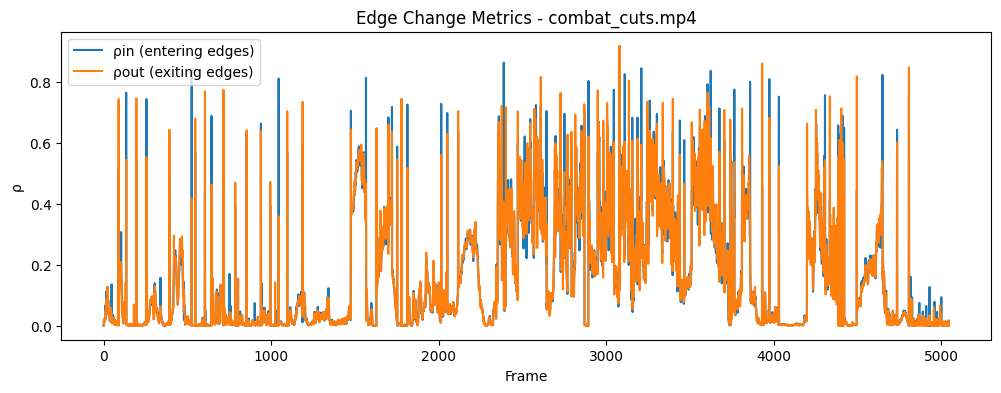

In [ ]:
def dilate_edges(edge_map, kernel_size=3):
    """Dilate edge map"""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.dilate(edge_map, kernel)


for video_name, video_data in edges.items():
    edge_maps = video_data["edge_maps"]
    frame_count = edge_maps.shape[0]

    print(f"Processing {frame_count} frames for video {video_name.name}")

    rho_in_list = []
    rho_out_list = []

    for t in tqdm(range(frame_count - 1)):
        E_t = edge_maps[t]
        E_t1 = edge_maps[t + 1]

        # Dilated edge maps
        D_t = dilate_edges(E_t)
        D_t1 = dilate_edges(E_t1)

        sum_E_t1 = np.sum(E_t1)
        if sum_E_t1 > 0:
            rho_in = 1 - np.sum(D_t & E_t1) / sum_E_t1
        else:
            rho_in = 0

        sum_E_t = np.sum(E_t)
        if sum_E_t > 0:
            rho_out = 1 - np.sum(E_t & D_t1) / sum_E_t
        else:
            rho_out = 0

        rho_in_list.append(rho_in)
        rho_out_list.append(rho_out)

    print(f"Video: {video_name.name}")
    print(
        f"Mean ρin: {np.mean(rho_in_list):.4f}, Mean ρout: {np.mean(rho_out_list):.4f}"
    )

    # Plot the metrics
    plt.figure(figsize=(12, 4))
    plt.plot(rho_in_list, label="ρin (entering edges)")
    plt.plot(rho_out_list, label="ρout (exiting edges)")
    plt.xlabel("Frame")
    plt.ylabel("ρ")
    plt.legend()
    plt.title(f"Edge Change Metrics - {video_name.name}")
    plt.show()